In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta 
from sklearn.preprocessing import StandardScaler

### Load dataset

Make sure that training and validation set end at episode.

In [2]:
dataset = pd.read_csv("GMM_values.csv", header=0)

In [3]:
#get failure times 
failurePoints = []
for index, row in dataset.iterrows():
    current_state = row['State']
    if current_state > 3:
        failurePoints.append(row['Timestep'])

In [4]:
def getRUL(current, failurelst):
    nextFailure = None
    for f in failurelst:
        if f - current >= 0: 
            nextFailure = f
            break 
    if nextFailure != None:
        diff = nextFailure - current 
        return diff
    else: 
        return None

In [5]:
#investigate general trend of RUL values 
total_rul = []
timeX = dataset['Timestep'].tolist()
for instance in timeX:
    current_rul = getRUL(instance, failurePoints)
    total_rul.append(current_rul)

In [6]:
#create a new dataframe with RUL 
all_df = dataset.copy(deep=True)
all_df['RUL'] = total_rul

In [7]:
#drop na columns 
all_df = all_df.dropna()

In [8]:
#split data into episodes
data_split = []
chunkBySize = []
for index, row in all_df.iterrows():
    currentRUL = row['RUL']
    arr = [row['Timestep'], row['Volt'], row['Rotate'], row['Pressure'], row['Vibration'], row['RUL'], row['State']]
    if currentRUL < 1:  
        chunkBySize.append(arr)
        if (chunkBySize):
            data_split.append(chunkBySize)
        chunkBySize = []
    else:
        chunkBySize.append(arr)

In [9]:
#split in training, validation and test sets

num_episodes = len(data_split)
num_train = int(0.75*num_episodes)
num_val = int(0.125*num_episodes)

train_data = data_split[:num_train]
val_data = data_split[num_train:num_train+num_val]
test_data = data_split[num_train+num_val:]

In [10]:
def getSensorReadingsOnlyNoEpisode(lst):
    result = []
    time = []
    for episode in lst:
        for row in episode:
            row_formatted = row[1:5]
            result.append(row_formatted)
            time.append(row[0])
    return (result, time)

In [11]:
#set random seed 
import tensorflow as tf
tf.random.set_seed(42)

In [12]:
train_arr, trainTime = getSensorReadingsOnlyNoEpisode(train_data)
val_arr, valTime = getSensorReadingsOnlyNoEpisode(val_data)
test_arr, testTime = getSensorReadingsOnlyNoEpisode(test_data)

In [13]:
train_arr

[[0.379151092, 0.556385187, 0.243079506, 0.229504293],
 [0.415506993, 0.698561103, 0.242410288, 0.273824561],
 [0.33934205, 0.637644818, 0.230266358, 0.191588098],
 [0.343817356, 0.627731997, 0.233904513, 0.264566349],
 [0.310361557, 0.607368113, 0.194295643, 0.240200195],
 [0.336327636, 0.531479142, 0.215693485, 0.215780325],
 [0.397831149, 0.57521239, 0.190585546, 0.230599092],
 [0.385974096, 0.630933953, 0.208516333, 0.247693397],
 [0.376943194, 0.396047283, 0.215659658, 0.256992779],
 [0.56498231, 0.648197926, 0.516587151, 0.256162471],
 [0.351867147, 0.647795783, 0.257161825, 0.276671218],
 [0.353867353, 0.615858294, 0.197009134, 0.269388231],
 [0.384169823, 0.622861995, 0.199791766, 0.305659257],
 [0.353154082, 0.597895409, 0.2172971, 0.265631153],
 [0.382126061, 0.655505276, 0.231748822, 0.258702261],
 [0.374770865, 0.676145451, 0.243662648, 0.259956326],
 [0.406003625, 0.626204276, 0.246397078, 0.26882794],
 [0.351261256, 0.265259177, 0.168831064, 0.441434541],
 [0.322982599, 0

In [14]:
def getStateValues(lst):
    stateList = []
    for episode in lst:
        for row in episode:
            stateValue = int(row[6])
            stateList.append(stateValue)
    return stateList

In [15]:
train_state = getStateValues(train_data)
val_state = getStateValues(val_data)
test_state = getStateValues(test_data)

In [16]:
total_num = len(train_state)
failure_states = [i for i in train_state if i > 3]
failure_num = len(failure_states)
outlier_ratio = failure_num/total_num
print("Estimated percentage of outliers %f" % outlier_ratio)

Estimated percentage of outliers 0.083361


In [17]:
def viewOutliers(clf):
    #training set
    y_train_scores = clf.decision_scores_
    plt.hist(y_train_scores, bins='auto') 
    plt.title("Histogram for training set anomaly scores")
    plt.show()
    
    #validation set
    y_val_scores = clf.decision_function(val_arr)  # outlier scores
    y_val_scores = pd.Series(y_val_scores)
    plt.hist(y_val_scores, bins='auto') 
    plt.title("Histogram for validation set anomaly scores")
    plt.show()

### Train isolation forest

In [18]:
from pyod.models.iforest import IForest
clf100 = IForest(bootstrap=True, random_state=42, contamination=outlier_ratio)
clf100.fit(train_arr)
clf100.get_params()

{'behaviour': 'old',
 'bootstrap': True,
 'contamination': 0.08336106489184693,
 'max_features': 1.0,
 'max_samples': 'auto',
 'n_estimators': 100,
 'n_jobs': 1,
 'random_state': 42,
 'verbose': 0}

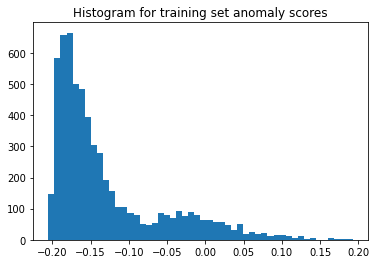

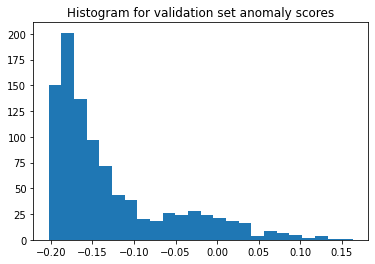

In [19]:
from pyod.models.iforest import IForest
clf1 = IForest(bootstrap=True, random_state=42, contamination=outlier_ratio)
clf1.fit(train_arr)
viewOutliers(clf1)

In [20]:
import statistics
#find mean 
train_score = clf1.decision_function(train_arr)
trainMean = statistics.mean(train_score)
trainMean

-0.12962691812285795

In [21]:
#find standard deviation
trainStdev = statistics.stdev(train_score)
trainStdev

0.07232779928799467

In [22]:
def countPercentage(scores, threshold):
    count = 0
    for s in scores:
        if s >= threshold:
            count += 1
    return count/len(scores)

In [23]:
countPercentage(train_score, 0)

0.08336106489184693

In [24]:
def findFailureIndex(data):
    orderlist = []
    for order in range(len(data)):
        if data[order] > 3:
            orderlist.append(order)
    return orderlist

In [25]:
def findDegradeIndex(data): #includes state 3
    orderlist = []
    for order in range(len(data)):
        if data[order] > 2:
            orderlist.append(order)
    return orderlist

In [26]:
def getNormalIndex(data):
    orderlist = []
    for order in range(len(data)):
        if data[order] < 4:
            orderlist.append(order)
    return orderlist

In [27]:
def getValuebyIndex(data, indexList):
    output = []
    for order in indexList:
        output.append(data[order])
    return output

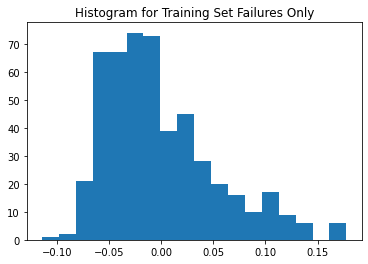

In [28]:
#failure anomaly scores 
train_failureIndex = findFailureIndex(train_state)
train_failureScores = getValuebyIndex(train_score, train_failureIndex)
plt.hist(train_failureScores, bins='auto')
plt.title("Histogram for Training Set Failures Only")
plt.show()

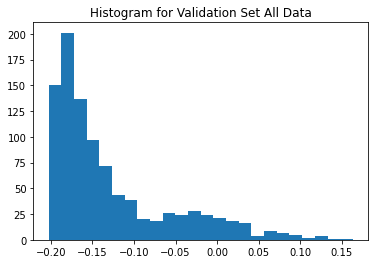

In [29]:
val_score = clf1.decision_function(val_arr)
plt.hist(val_score, bins='auto')
plt.title("Histogram for Validation Set All Data")
plt.show()

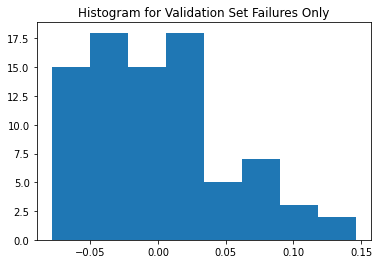

In [30]:
#failure data 
val_failureIndex = findFailureIndex(val_state)
val_failureScores = getValuebyIndex(val_score, val_failureIndex)
plt.hist(val_failureScores, bins='auto')
plt.title("Histogram for Validation Set Failures Only")
plt.show()

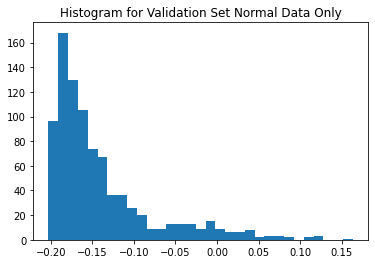

In [31]:
#normal data 
val_normalIndex = getNormalIndex(val_state)
val_normalScores = getValuebyIndex(val_score, val_normalIndex)
plt.hist(val_normalScores, bins='auto')
plt.title("Histogram for Validation Set Normal Data Only")
plt.show()

In [32]:
#find mean (validation)
valMean = statistics.mean(val_normalScores)
valMean

-0.1405692349117381

In [33]:
#find standard deviation (validation)
valStdev = statistics.stdev(val_normalScores)
valStdev

0.06234159958415319

In [34]:
allValuesList = dataset.values.tolist()
allValuesList

[[0.0, 0.379151092, 0.556385187, 0.243079506, 0.229504293, 0.0],
 [1.0, 0.415506993, 0.698561103, 0.242410288, 0.273824561, 1.0],
 [2.0, 0.33934205, 0.637644818, 0.230266358, 0.191588098, 2.0],
 [3.0, 0.343817356, 0.627731997, 0.233904513, 0.264566349, 2.0],
 [4.0, 0.310361557, 0.607368113, 0.194295643, 0.240200195, 2.0],
 [5.0, 0.336327636, 0.531479142, 0.215693485, 0.215780325, 2.0],
 [6.0, 0.397831149, 0.57521239, 0.190585546, 0.230599092, 2.0],
 [7.0, 0.385974096, 0.630933953, 0.208516333, 0.247693397, 2.0],
 [8.0, 0.376943194, 0.396047283, 0.215659658, 0.256992779, 3.0],
 [9.0, 0.56498231, 0.648197926, 0.516587151, 0.256162471, 4.0],
 [10.0, 0.351867147, 0.647795783, 0.257161825, 0.276671218, 0.0],
 [11.0, 0.353867353, 0.615858294, 0.197009134, 0.269388231, 0.0],
 [12.0, 0.384169823, 0.622861995, 0.199791766, 0.305659257, 0.0],
 [13.0, 0.353154082, 0.597895409, 0.2172971, 0.265631153, 1.0],
 [14.0, 0.382126061, 0.655505276, 0.231748822, 0.258702261, 2.0],
 [15.0, 0.374770865, 0.67

In [35]:
def processAnomalyWithoutState3(anomalyScores, data, threshold, dataType):
    
    #initialise variables
    anomalousStateListTrain = []
    anomalousStatePreListTrain = []
    anomalousStatePostListTrain = []
    anomalousCountTrain = 0
    
    anomalousStateListVal = []
    anomalousStatePreListVal = []
    anomalousStatePostListVal = []
    anomalousCountVal = 0
    
    anomalousStateListTest = []
    anomalousStatePreListTest = []
    anomalousStatePostListTest = []
    anomalousCountTest = 0
    
    for order in range(0, len(anomalyScores)):
        score = anomalyScores[order]
        if score > threshold: #is anomaly
            reading = data[order].tolist()
            
            #process anomaly and count 
            anomalousIndex = 0
            for n in range(0, len(allValuesList)):
                row = allValuesList[n]
                if row[1:5] == reading: #is anomaly
                    anomalousIndex = n
                    if (dataType == 'Train'):
                        anomalousStateListTrain.append(allValuesList[anomalousIndex][5])
                        anomalousStatePreListTrain.append(allValuesList[anomalousIndex-1][5])
                        anomalousStatePostListTrain.append(allValuesList[anomalousIndex+1][5])
                        anomalousCountTrain =  anomalousCountTrain + 1
                    elif (dataType == 'Val'):
                        anomalousStateListVal.append(allValuesList[anomalousIndex][5])
                        anomalousStatePreListVal.append(allValuesList[anomalousIndex-1][5])
                        anomalousStatePostListVal.append(allValuesList[anomalousIndex+1][5])
                        anomalousCountVal =  anomalousCountVal + 1
                    elif (dataType == 'Test'):
                        anomalousStateListTest.append(allValuesList[anomalousIndex][5])
                        anomalousStatePreListTest.append(allValuesList[anomalousIndex-1][5])
                        anomalousStatePostListTest.append(allValuesList[anomalousIndex+1][5])
                        anomalousCountTest =  anomalousCountTest + 1
                    break
        
    #graphical analysis 
    if (dataType == 'Train'):
        graphData = anomalousStateListTrain
    elif (dataType == 'Val'):
        graphData = anomalousStateListVal
    elif (dataType == 'Test'):
        graphData = anomalousStateListTest
        
    plt.hist(graphData, bins=[0,1,2,3,4,8,9])
    plt.title(f'Current anomalous state - {dataType}')
    plt.show()
    
    #numerical analysis 
    if (dataType == 'Train'):
        #training set
        train4count = anomalousStateListTrain.count(4.0)
        train5count = anomalousStateListTrain.count(5.0)
        train45count = train4count + train5count
        traintotalcount = len(anomalousStateListTrain)
        train4percent = train4count/traintotalcount
        train5percent = train5count/traintotalcount
        train45percent = train45count/traintotalcount
        print("Percentage of anomalies identified belonging to state 4 and state 5 in training set: %f" % train45percent)
        
        orgTrain4Count = train_state.count(4)
        orgTrain5Count = train_state.count(5)
        orgTrain45Count = orgTrain4Count + orgTrain5Count
        orgtrain4percent = train4count/orgTrain4Count
        orgtrain5percent = train5count/orgTrain5Count
        orgtrain45percent = train45count/orgTrain45Count
        print("Percentage of points in state 4 and 5 in training set identified as anomalies: %f" % orgtrain45percent)
    elif (dataType == 'Val'): #validation set
        val4count = anomalousStateListVal.count(4.0)
        val5count = anomalousStateListVal.count(5.0)
        val45count = val4count + val5count
        valtotalcount = len(anomalousStateListVal)
        val4percent = val4count/valtotalcount
        val5percent = val5count/valtotalcount
        val45percent = val45count/valtotalcount
        print("Percentage of anomalies identified belonging to state 4 and state 5 in validation set: %f" % val45percent)
        
        orgVal4Count = val_state.count(4)
        orgVal5Count = val_state.count(5)
        orgVal45Count = orgVal4Count + orgVal5Count
        orgVal4percent = val4count/orgVal4Count
        orgVal5percent = val5count/orgVal5Count
        orgVal45percent = val45count/orgVal45Count
        print("Percentage of points in state 4 and 5 in validation set identified as anomalies: %f" % orgVal45percent)
    elif (dataType == 'Test'): #test set
        test4count = anomalousStateListTest.count(4.0)
        test5count = anomalousStateListTest.count(5.0)
        test45count = test4count + test5count
        testtotalcount = len(anomalousStateListTest)
        test4percent = test4count/testtotalcount
        test5percent = test5count/testtotalcount
        test45percent = test45count/testtotalcount
        print("Percentage of anomalies identified belonging to state 4 and state 5 in test set: %f" % test45percent)
        
        orgTest4Count = test_state.count(4)
        orgTest5Count = test_state.count(5)
        orgTest45Count = orgTest4Count + orgTest5Count
        orgTest4percent = test4count/orgTest4Count
        orgTest5percent = test5count/orgTest5Count
        orgTest45percent = test45count/orgTest45Count
        print("Percentage of points in state 4 and 5 in test set identified as anomalies: %f" % orgTest45percent)

In [36]:
def processAnomalyWithState3(anomalyScores, data, threshold, dataType):
    
    #initialise variables
    anomalousStateListTrain = []
    anomalousStatePreListTrain = []
    anomalousStatePostListTrain = []
    anomalousCountTrain = 0
    
    anomalousStateListVal = []
    anomalousStatePreListVal = []
    anomalousStatePostListVal = []
    anomalousCountVal = 0
    
    anomalousStateListTest = []
    anomalousStatePreListTest = []
    anomalousStatePostListTest = []
    anomalousCountTest = 0
    
    for order in range(0, len(anomalyScores)):
        score = anomalyScores[order]
        if score > threshold: #is anomaly
            reading = data[order].tolist()
            
            #process anomaly and count 
            anomalousIndex = 0
            for n in range(0, len(allValuesList)):
                row = allValuesList[n]
                if row[1:5] == reading: #is anomaly
                    anomalousIndex = n
                    if (dataType == 'Train'):
                        anomalousStateListTrain.append(allValuesList[anomalousIndex][5])
                        anomalousStatePreListTrain.append(allValuesList[anomalousIndex-1][5])
                        anomalousStatePostListTrain.append(allValuesList[anomalousIndex+1][5])
                        anomalousCountTrain =  anomalousCountTrain + 1
                    elif (dataType == 'Val'):
                        anomalousStateListVal.append(allValuesList[anomalousIndex][5])
                        anomalousStatePreListVal.append(allValuesList[anomalousIndex-1][5])
                        anomalousStatePostListVal.append(allValuesList[anomalousIndex+1][5])
                        anomalousCountVal =  anomalousCountVal + 1
                    elif (dataType == 'Test'):
                        anomalousStateListTest.append(allValuesList[anomalousIndex][5])
                        anomalousStatePreListTest.append(allValuesList[anomalousIndex-1][5])
                        anomalousStatePostListTest.append(allValuesList[anomalousIndex+1][5])
                        anomalousCountTest =  anomalousCountTest + 1
                    break
        
    #graphical analysis 
    if (dataType == 'Train'):
        graphData = anomalousStateListTrain
    elif (dataType == 'Val'):
        graphData = anomalousStateListVal
    elif (dataType == 'Test'):
        graphData = anomalousStateListTest
        
    plt.hist(graphData, bins=[0,1,2,3,4,5,6])
    plt.title(f'Current anomalous state - {dataType}')
    plt.show()
    
    #numerical analysis 
    if (dataType == 'Train'):
        #training set
        train3count = anomalousStateListTrain.count(3.0)
        train4count = anomalousStateListTrain.count(4.0)
        train5count = anomalousStateListTrain.count(5.0)
        train345count = train3count + train4count + train5count
        traintotalcount = len(anomalousStateListTrain)
        train345percent = train345count/traintotalcount
        print("Percentage of anomalies identified belonging to state 3, 4 and 5 in training set: %f" % train345percent)
        
        orgTrain3Count = train_state.count(3)
        orgTrain4Count = train_state.count(4)
        orgTrain5Count = train_state.count(5)
        orgTrain345Count = orgTrain3Count + orgTrain4Count + orgTrain5Count
        orgtrain345percent = train345count/orgTrain345Count
        print("Percentage of points in state 3, 4 and 5 in training set identified as anomalies: %f" % orgtrain345percent)
    elif (dataType == 'Val'): #validation set
        val3count = anomalousStateListVal.count(3.0)
        val4count = anomalousStateListVal.count(4.0)
        val5count = anomalousStateListVal.count(5.0)
        val345count = val3count + val4count + val5count
        valtotalcount = len(anomalousStateListVal)
        val345percent = val345count/valtotalcount
        print("Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: %f" % val345percent)
        
        orgVal3Count = val_state.count(3)
        orgVal4Count = val_state.count(4)
        orgVal5Count = val_state.count(5)
        orgVal345Count = orgVal3Count + orgVal4Count + orgVal5Count
        orgVal345percent = val345count/orgVal345Count
        print("Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: %f" % orgVal345percent)
    elif (dataType == 'Test'): #test set
        test3count = anomalousStateListTest.count(3.0)
        test4count = anomalousStateListTest.count(4.0)
        test5count = anomalousStateListTest.count(5.0)
        test345count = test3count + test4count + test5count
        testtotalcount = len(anomalousStateListTest)
        test345percent = test345count/testtotalcount
        print("Percentage of anomalies identified belonging to state 3, 4 and 5 in test set: %f" % test345percent)
        
        orgTest3Count = test_state.count(3)
        orgTest4Count = test_state.count(4)
        orgTest5Count = test_state.count(5)
        orgTest345Count = orgTest3Count + orgTest4Count + orgTest5Count
        orgTest345percent = test345count/orgTest345Count
        print("Percentage of points in state 3, 4 and 5 in test set identified as anomalies: %f \n" % orgTest345percent)

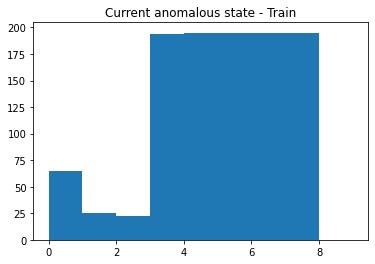

Percentage of anomalies identified belonging to state 4 and state 5 in training set: 0.389222
Percentage of points in state 4 and 5 in training set identified as anomalies: 0.389222


In [37]:
#Validation data
processAnomalyWithoutState3(train_score, np.array(train_arr), 0, 'Train')

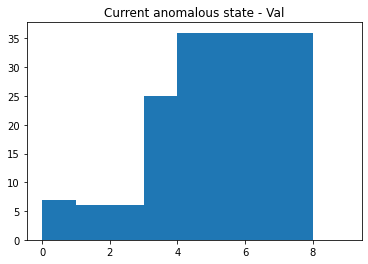

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.450000
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.433735


In [38]:
#Validation data
processAnomalyWithoutState3(val_score, np.array(val_arr), 0, 'Val')

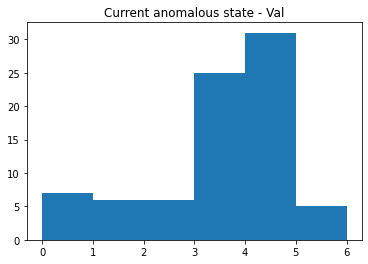

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.762500
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.221014


In [37]:
#Validation data
processAnomalyWithState3(val_score, np.array(val_arr), 0, 'Val')

### Hyperparameter tuning

Change n_estimators

Number of estimators: 200


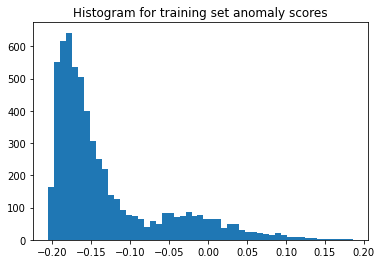

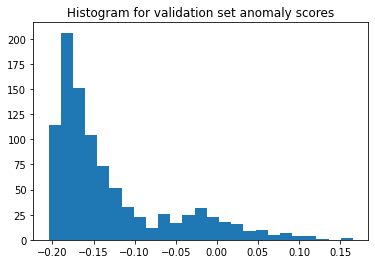

Mean: -0.1413. Stdev 0.0624. 1 Stdev away: -0.0789. 2 Stdev away -0.0165.
Number of estimators: 400


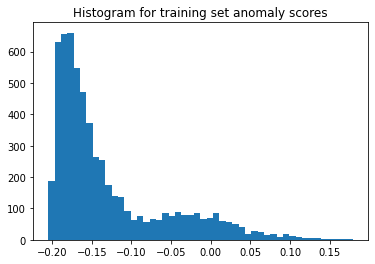

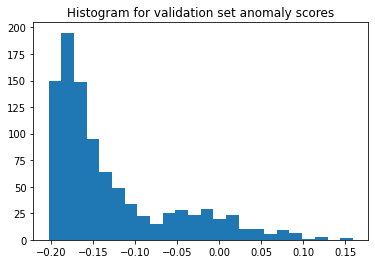

Mean: -0.1410. Stdev 0.0622. 1 Stdev away: -0.0788. 2 Stdev away -0.0166.
Number of estimators: 600


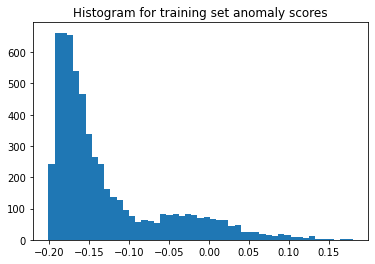

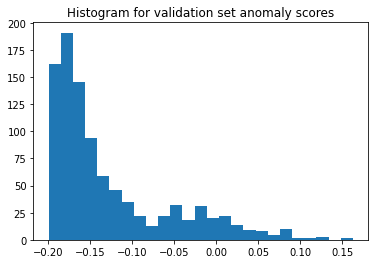

Mean: -0.1399. Stdev 0.0618. 1 Stdev away: -0.0781. 2 Stdev away -0.0163.
Number of estimators: 800


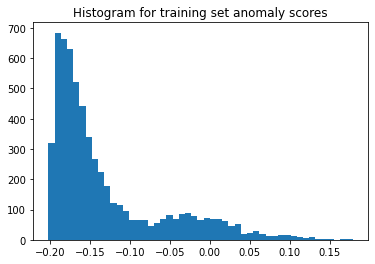

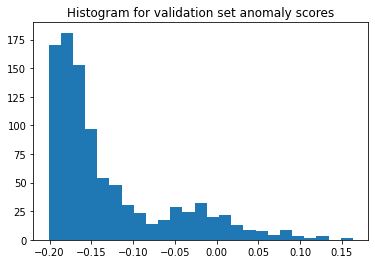

Mean: -0.1415. Stdev 0.0622. 1 Stdev away: -0.0792. 2 Stdev away -0.0170.
Number of estimators: 1000


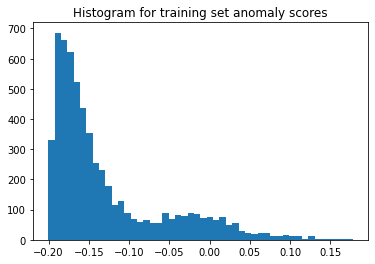

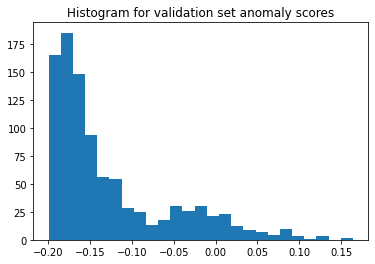

Mean: -0.1395. Stdev 0.0619. 1 Stdev away: -0.0776. 2 Stdev away -0.0157.


In [38]:
n_estimatorslist = [200, 400, 600, 800, 1000]
for num in n_estimatorslist:
    print("Number of estimators: %d" % num)
    clf2 = IForest(bootstrap=True, n_estimators=num, random_state=42, contamination=outlier_ratio)
    clf2.fit(train_arr)
    viewOutliers(clf2)
    
    #calculate mean and stdev 
    val_score2 = clf2.decision_function(val_arr)
    val_normalIndex2 = getNormalIndex(val_state)
    val_normalScores2 = getValuebyIndex(val_score2, val_normalIndex2)
    valMean2 = statistics.mean(val_normalScores2)
    valStdev2 = statistics.stdev(val_normalScores2)
    val1Stdev2 = valMean2 + valStdev2
    val2Stdev2 = valMean2 + valStdev2*2
    
    print('Mean: %.4f. Stdev %.4f. 1 Stdev away: %.4f. 2 Stdev away %.4f.' % (valMean2, valStdev2, val1Stdev2, val2Stdev2))

Number of estimators: 200


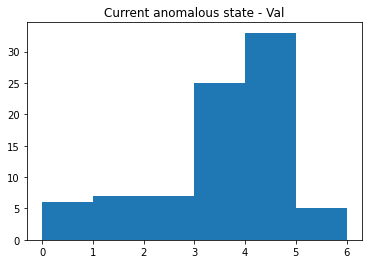

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.457831
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.457831


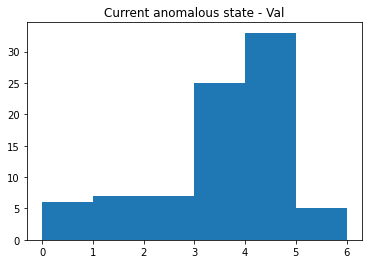

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.759036
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.228261
Number of estimators: 400


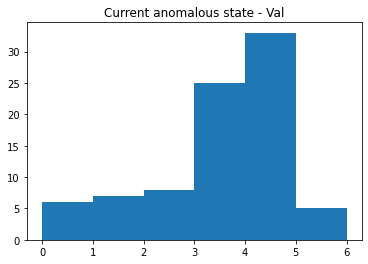

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.452381
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.457831


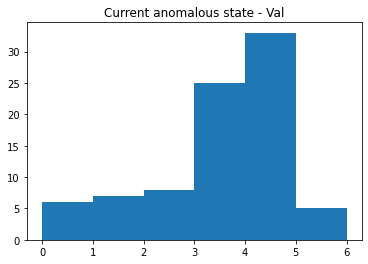

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.750000
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.228261
Number of estimators: 600


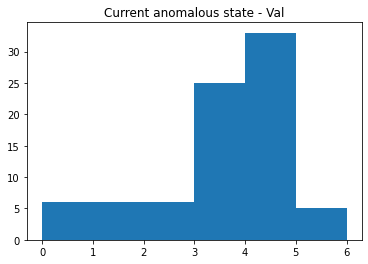

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.469136
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.457831


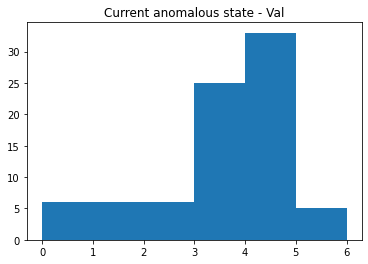

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.777778
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.228261
Number of estimators: 800


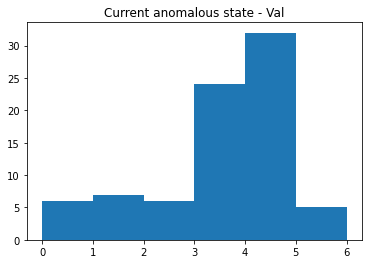

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.462500
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.445783


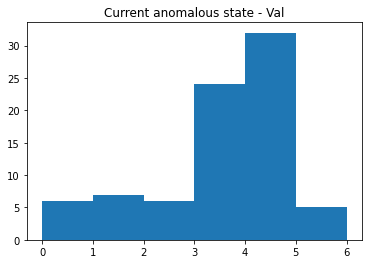

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.762500
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.221014
Number of estimators: 1000


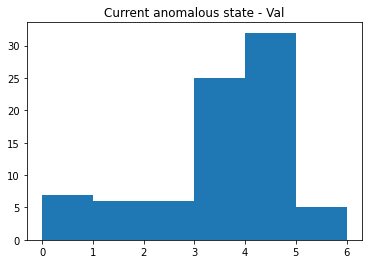

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.456790
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.445783


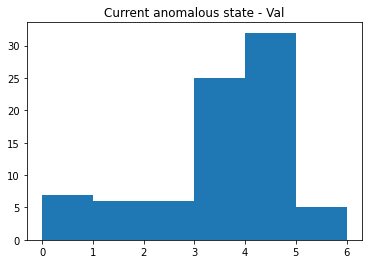

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.765432
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.224638


In [39]:
n_estimatorslist = [200, 400, 600, 800, 1000]
for order in range(len(n_estimatorslist)):
    n_estimator = n_estimatorslist[order]
    print("Number of estimators: %d" % n_estimator)
    clf2 = IForest(bootstrap=True, n_estimators=n_estimator, random_state=42, contamination=outlier_ratio)
    clf2.fit(train_arr)
    
    val_score2 = clf2.decision_function(val_arr)
    
    processAnomalyWithoutState3(val_score2, np.array(val_arr), 0, 'Val')
    processAnomalyWithState3(val_score2, np.array(val_arr), 0, 'Val')

n_estimators = 600 seems to give good performance but with lower rates of false alarms.

Change max samples

Max samples: 120


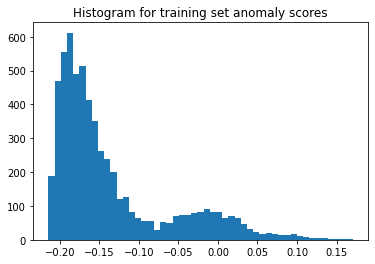

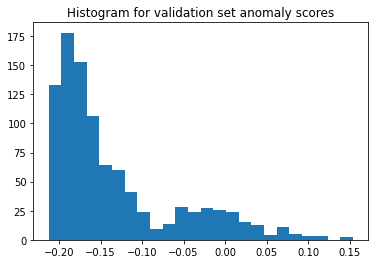

Mean: -0.1469. Stdev 0.0639. 1 Stdev away: -0.0829. 2 Stdev away -0.0190.
Max samples: 240


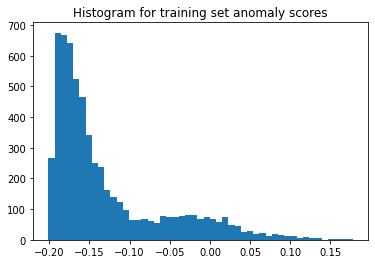

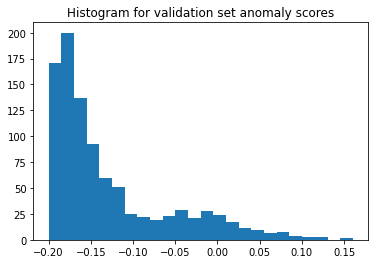

Mean: -0.1401. Stdev 0.0620. 1 Stdev away: -0.0781. 2 Stdev away -0.0161.
Max samples: 480


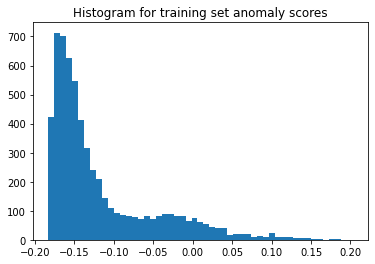

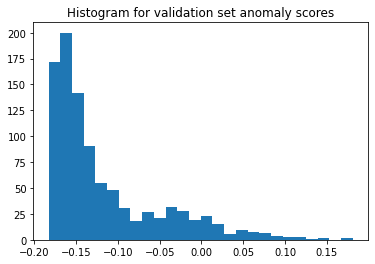

Mean: -0.1274. Stdev 0.0583. 1 Stdev away: -0.0691. 2 Stdev away -0.0108.
Max samples: 960


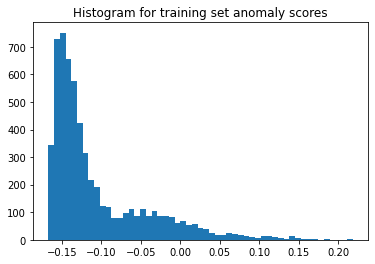

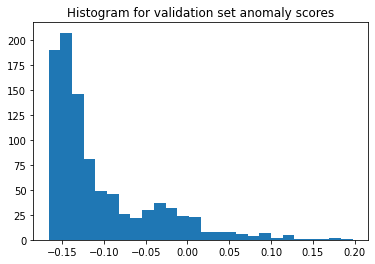

Mean: -0.1143. Stdev 0.0552. 1 Stdev away: -0.0591. 2 Stdev away -0.0039.
Max samples: 2400


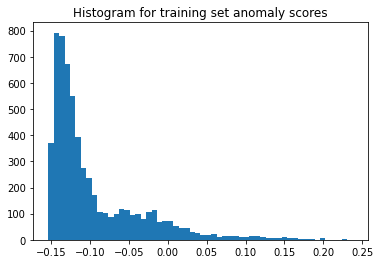

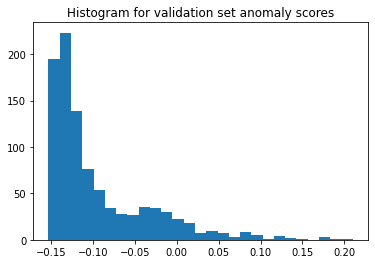

Mean: -0.1043. Stdev 0.0525. 1 Stdev away: -0.0518. 2 Stdev away 0.0006.
Max samples: 4800


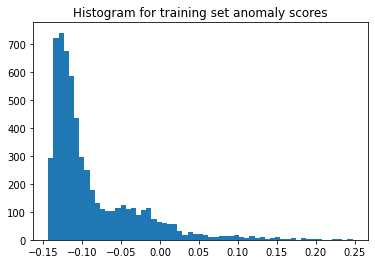

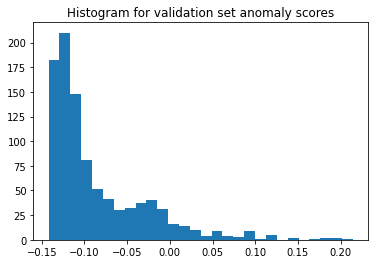

Mean: -0.0946. Stdev 0.0499. 1 Stdev away: -0.0446. 2 Stdev away 0.0053.


In [40]:
max_samples_list = [120, 240, 480, 960, 2400, 4800]
for num in max_samples_list:
    print("Max samples: %d" % num)
    clf3 = IForest(bootstrap=True, n_estimators=600, max_samples=num, random_state=42, contamination=outlier_ratio)
    clf3.fit(train_arr)
    viewOutliers(clf3)
    
    #calculate mean and stdev 
    val_score3 = clf3.decision_function(val_arr)
    val_normalIndex3 = getNormalIndex(val_state)
    val_normalScores3 = getValuebyIndex(val_score3, val_normalIndex3)
    valMean3 = statistics.mean(val_normalScores3)
    valStdev3 = statistics.stdev(val_normalScores3)
    val1Stdev3 = valMean3 + valStdev3
    val2Stdev3 = valMean3 + valStdev3*2
    
    print('Mean: %.4f. Stdev %.4f. 1 Stdev away: %.4f. 2 Stdev away %.4f.' % (valMean3, valStdev3, val1Stdev3, val2Stdev3))

Max samples: 120


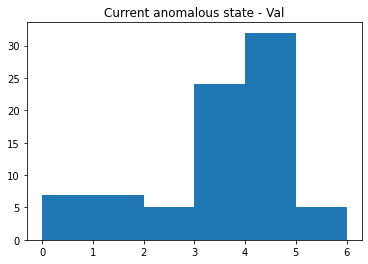

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.462500
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.445783


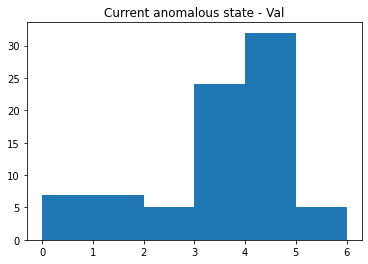

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.762500
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.221014
Max samples: 240


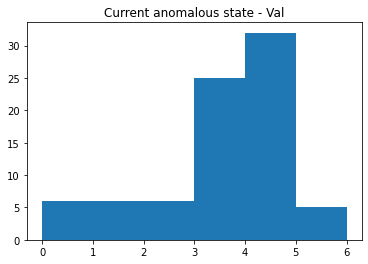

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.462500
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.445783


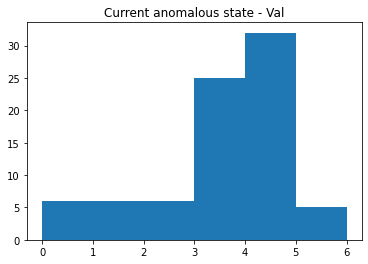

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.775000
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.224638
Max samples: 480


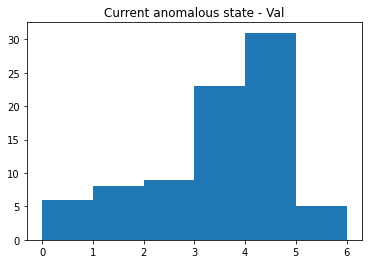

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.439024
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.433735


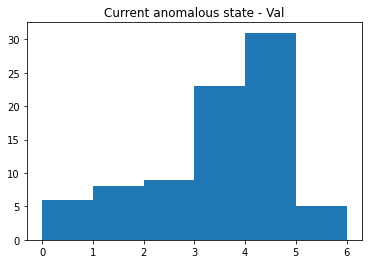

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.719512
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.213768
Max samples: 960


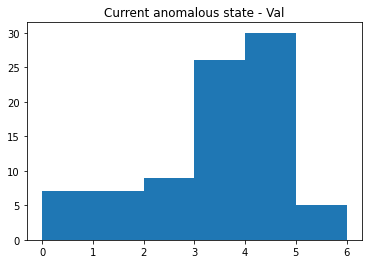

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.416667
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.421687


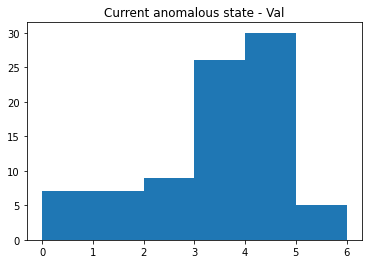

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.726190
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.221014
Max samples: 2400


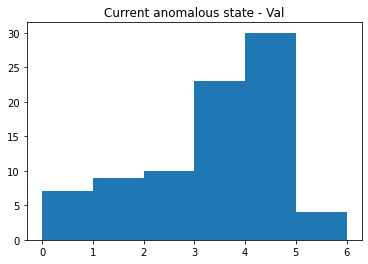

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.409639
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.409639


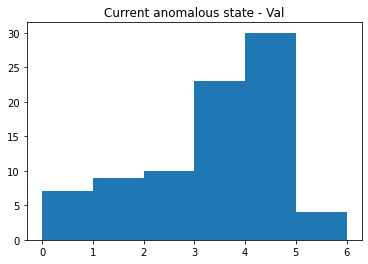

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.686747
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.206522
Max samples: 4800


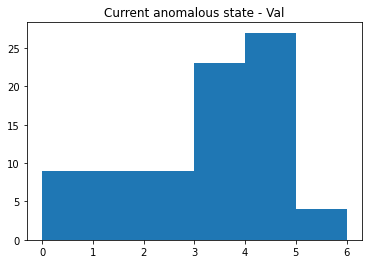

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.382716
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.373494


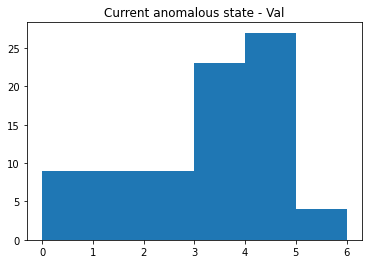

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.666667
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.195652


In [44]:
max_samples_list = [120, 240, 480, 960, 2400, 4800]
for order in range(len(max_samples_list)):
    max_sample = max_samples_list[order]
    print("Max samples: %d" % max_sample)
    clf3 = IForest(bootstrap=True, n_estimators=600, max_samples=max_sample, random_state=42, contamination=outlier_ratio)
    clf3.fit(train_arr)
    
    val_score3 = clf3.decision_function(val_arr)
    
    processAnomalyWithoutState3(val_score3, np.array(val_arr), 0, 'Val')
    processAnomalyWithState3(val_score3, np.array(val_arr), 0, 'Val')

120 max samples seems to give good performance with lower false positive rate.

Change max_features.

Max features: 1


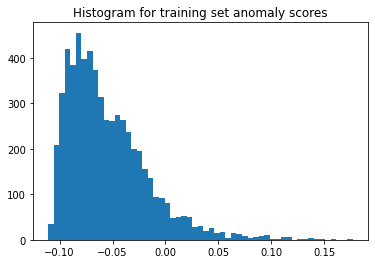

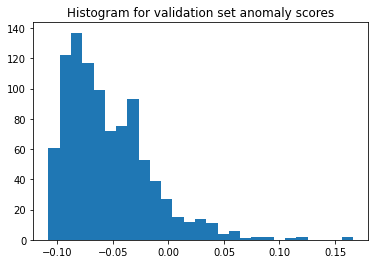

Mean: -0.0587. Stdev 0.0361. 1 Stdev away: -0.0225. 2 Stdev away 0.0136.
Max features: 2


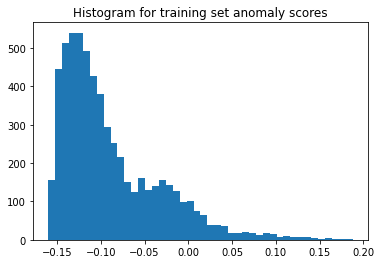

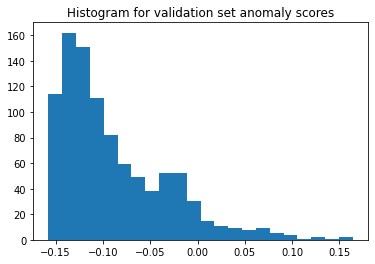

Mean: -0.0969. Stdev 0.0502. 1 Stdev away: -0.0468. 2 Stdev away 0.0034.
Max features: 3


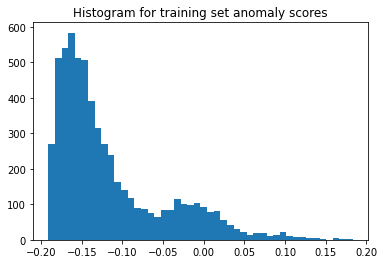

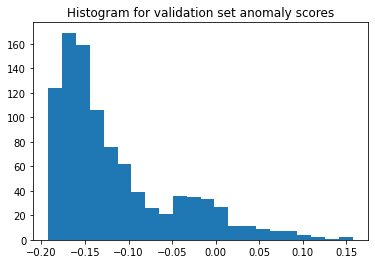

Mean: -0.1261. Stdev 0.0587. 1 Stdev away: -0.0674. 2 Stdev away -0.0088.
Max features: 4


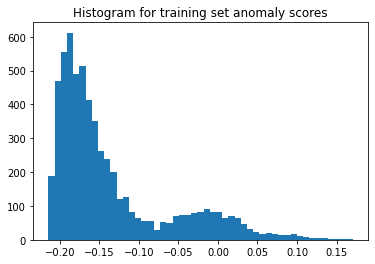

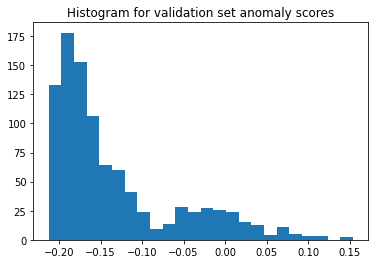

Mean: -0.1469. Stdev 0.0639. 1 Stdev away: -0.0829. 2 Stdev away -0.0190.


In [45]:
max_features_list = [1,2,3,4]
for num in max_features_list:
    print("Max features: %d" % num)
    clf4 = IForest(bootstrap=True, n_estimators=600, max_features=num, max_samples=120, random_state=42, contamination=outlier_ratio)
    clf4.fit(train_arr)
    viewOutliers(clf4)
    
    #calculate mean and stdev 
    val_score4 = clf4.decision_function(val_arr)
    val_normalIndex4 = getNormalIndex(val_state)
    val_normalScores4 = getValuebyIndex(val_score4, val_normalIndex4)
    valMean4 = statistics.mean(val_normalScores4)
    valStdev4 = statistics.stdev(val_normalScores4)
    val1Stdev4 = valMean4 + valStdev4
    val2Stdev4 = valMean4 + valStdev4*2
    
    print('Mean: %.4f. Stdev %.4f. 1 Stdev away: %.4f. 2 Stdev away %.4f.' % (valMean4, valStdev4, val1Stdev4, val2Stdev4))

Max features: 1


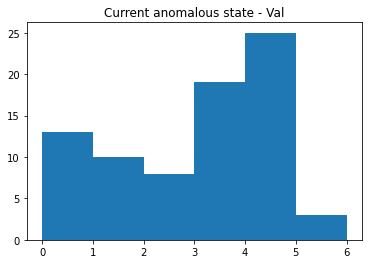

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.358974
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.337349


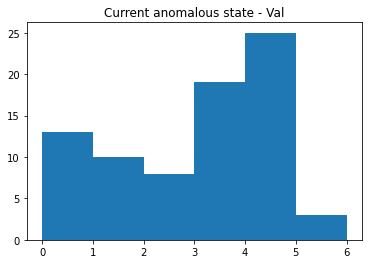

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.602564
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.170290
Max features: 2


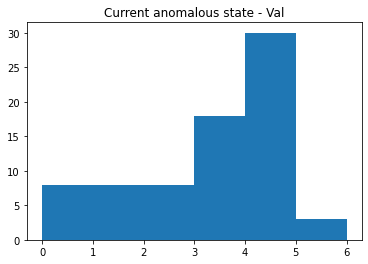

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.440000
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.397590


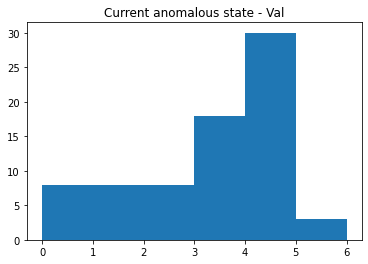

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.680000
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.184783
Max features: 3


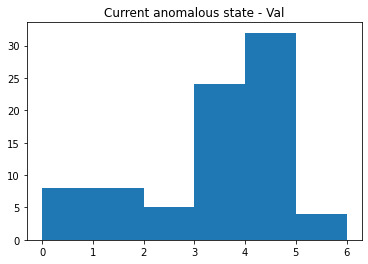

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.444444
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.433735


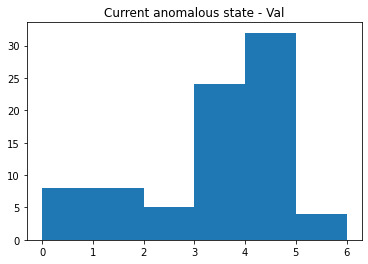

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.740741
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.217391
Max features: 4


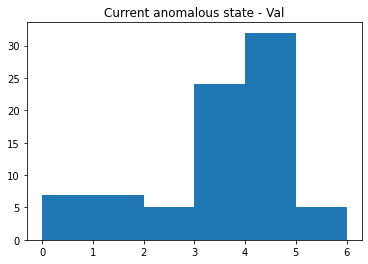

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.462500
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.445783


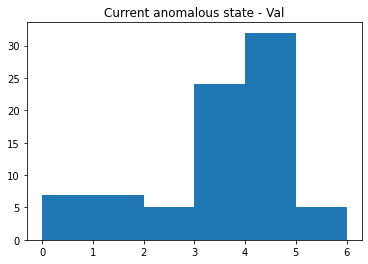

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.762500
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.221014


In [46]:
max_features_list = [1,2,3,4]
for order in range(len(max_features_list)):
    max_feature = max_features_list[order]
    print("Max features: %d" % max_feature)
    clf4 = IForest(bootstrap=True, n_estimators=600, max_features=max_feature, max_samples=120, random_state=42, contamination=outlier_ratio)
    clf4.fit(train_arr)
    
    val_score4 = clf4.decision_function(val_arr)
    
    processAnomalyWithoutState3(val_score4, np.array(val_arr), 0, 'Val')
    processAnomalyWithState3(val_score4, np.array(val_arr), 0, 'Val')

4 max features gave the best performance.

Try bootstrap as False

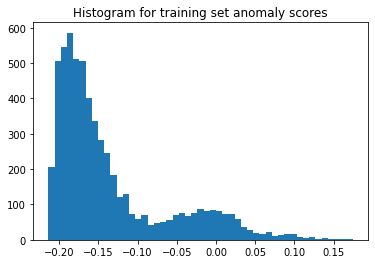

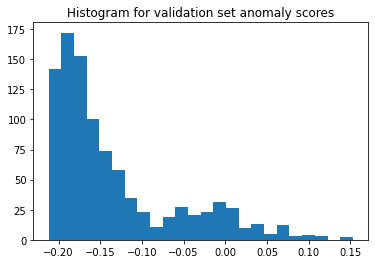

Mean: -0.1468. Stdev 0.0636. 1 Stdev away: -0.0832. 2 Stdev away -0.0196.


In [47]:
clf5 = IForest(bootstrap=False, n_estimators=600, max_samples=120, max_features=4, random_state=42, contamination=outlier_ratio)
clf5.fit(train_arr)
viewOutliers(clf5)

#calculate mean and stdev 
val_score5 = clf5.decision_function(val_arr)
val_normalIndex5 = getNormalIndex(val_state)
val_normalScores5 = getValuebyIndex(val_score5, val_normalIndex5)
valMean5 = statistics.mean(val_normalScores5)
valStdev5 = statistics.stdev(val_normalScores5)
val1Stdev5 = valMean5 + valStdev5
val2Stdev5 = valMean5 + valStdev5*2
    
print('Mean: %.4f. Stdev %.4f. 1 Stdev away: %.4f. 2 Stdev away %.4f.' % (valMean5, valStdev5, val1Stdev5, val2Stdev5))

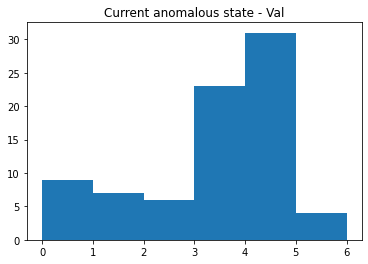

Percentage of anomalies identified belonging to state 4 and state 5 in validation set: 0.437500
Percentage of points in state 4 and 5 in validation set identified as anomalies: 0.421687


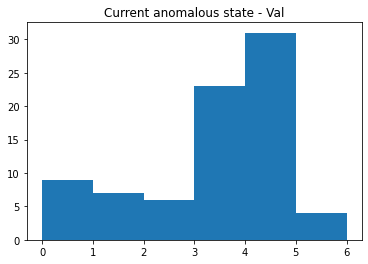

Percentage of anomalies identified belonging to state 3, 4 and 5 in validation set: 0.725000
Percentage of points in state 3, 4 and 5 in validation set identified as anomalies: 0.210145


In [48]:
processAnomalyWithoutState3(val_score5, np.array(val_arr), 0, 'Val')
processAnomalyWithState3(val_score5, np.array(val_arr), 0, 'Val')

Bootstrap = True gives a better performance